## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [3]:
# Проверка наличия пропущенных значений
missing_values = X.isnull().sum().sum()
if missing_values > 0:
    X.dropna(inplace=True)
    print("Пропущенные значения есть и мы только что их удалили")
else:
    print("Пропущенных значений нет в наборе данных")

Пропущенных значений нет в наборе данных


In [4]:
from sklearn.preprocessing import OneHotEncoder

# Проверка наличия категориальных переменных
categorical_cols = X.select_dtypes(include=['object']).columns
if not categorical_cols.empty:
    encoder = OneHotEncoder()
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]).toarray(), columns=encoder.get_feature_names(categorical_cols))
    X.drop(columns=categorical_cols, inplace=True)
    X = pd.concat([X, X_encoded], axis=1)
    print("Категориальные переменные были закодированы при помощи OneHot-кодирования")
else:
    print("Категориальных переменных нет в наборе данных")

Категориальных переменных нет в наборе данных


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Stratify разделяет данные так, чтобы сохранить пропорции наших классов в обучающей и тестовой выборке.
# Это важно, чтобы избежать смещения в распределении классов между обучением и тестированием, что может привести к неправильной оценке качества модели.
# Например, модель обучалась только на машинах, а в тестовой выборке у нее самолеты, она не сможет предсказать самолеты, если обучалась только на машинах.

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [7]:
X_train_subset = X_train[['alcohol', 'magnesium']]
X_test_subset = X_test[['alcohol', 'magnesium']]

scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)
X_test_subset_scaled = scaler.transform(X_test_subset)

neighbors = [1, 3, 5, 10, 15, 25]
classifiers = []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_subset_scaled, y_train)
    classifiers.append(knn)

train_accuracies = []
test_accuracies = []

for clf in classifiers:
    train_pred = clf.predict(X_train_subset_scaled)
    test_pred = clf.predict(X_test_subset_scaled)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

print("NN \t Train \t Test")
for i, n in enumerate(neighbors):
    print(f"{n} \t {train_accuracies[i]:.2f} \t {test_accuracies[i]:.2f}")

NN 	 Train 	 Test
1 	 1.00 	 0.56
3 	 0.80 	 0.63
5 	 0.78 	 0.63
10 	 0.75 	 0.65
15 	 0.72 	 0.63
25 	 0.69 	 0.69


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [8]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [9]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

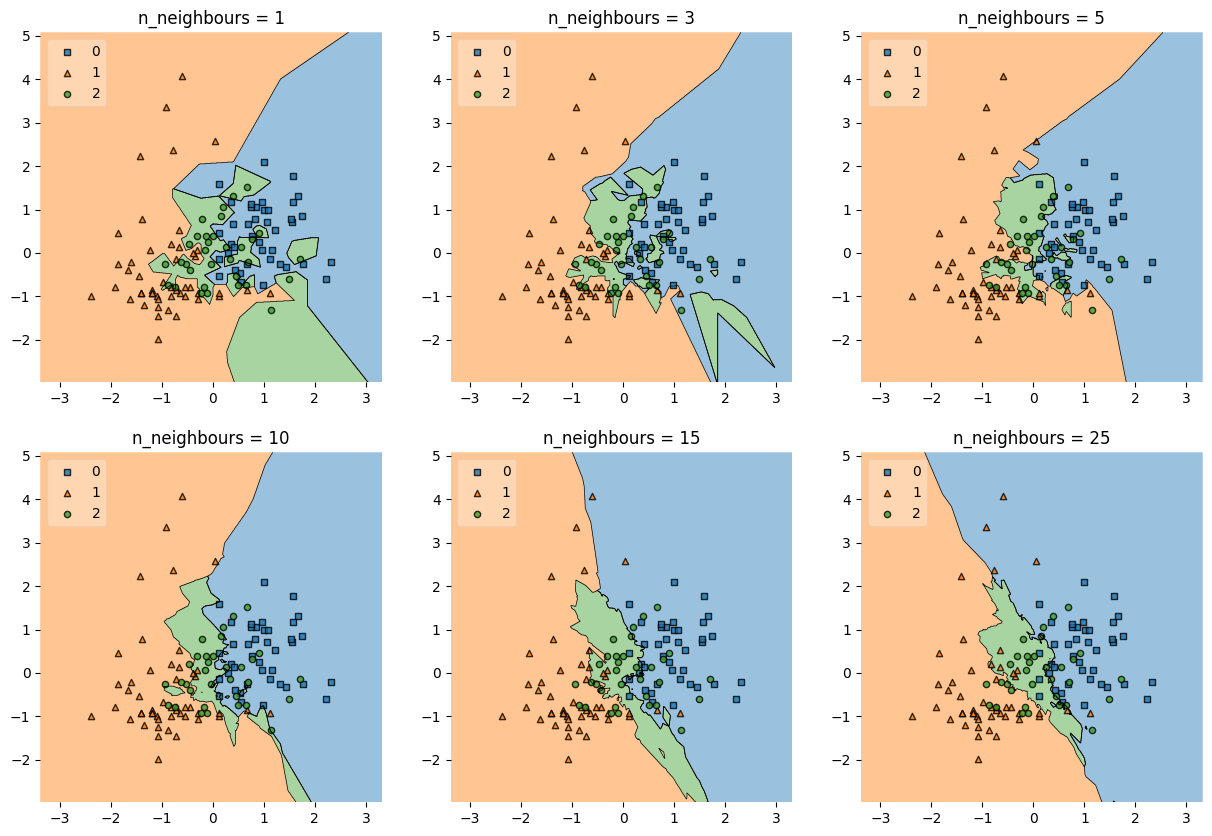

In [21]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from matplotlib import gridspec
import itertools

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(15, 10))

labels = ['n_neighbours = 1', 'n_neighbours = 3', 'n_neighbours = 5', 'n_neighbours = 10', 'n_neighbours = 15', 'n_neighbours = 25']

for clf, name, grd in zip(classifiers, labels, itertools.product([0, 1], [0, 1, 2])):
    plt.subplot(gs[grd[0], grd[1]])
    plot_decision_regions(np.array(X_train_subset_scaled), y_train, clf, scatter_kwargs={'s': 20}, legend=2)
    plt.title(name)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

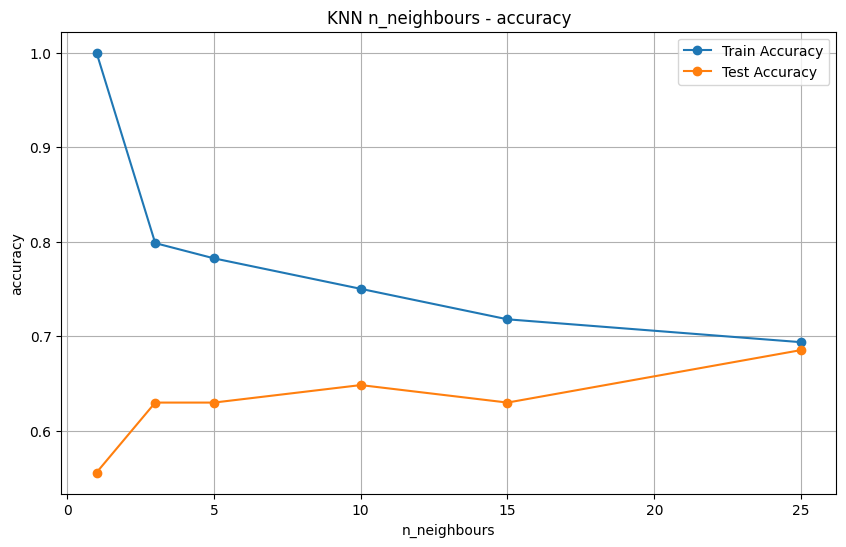

In [23]:
# Построим график-интерпретацию accuracy резултатов на тесте и на трейне
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(neighbors, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(neighbors, test_accuracies, marker='o', label='Test Accuracy')

plt.xlabel('n_neighbours')
plt.ylabel('accuracy')
plt.title('KNN n_neighbours - accuracy')
plt.legend()
plt.grid(True)
plt.show()

*    Видим, что значение на трейне все время падало, а значение на тесте росло, затем немного упало и снова начало расти.



*   Обычно оптимальным число соседей является 3 и 5, но все зависит, конечно же, от самих данных, от их предобработки, от способов масштабирования. Главное сранвить качество предсказаний и выбрать наилучший вариант по нужной метрике.


*   Конкретно в моих предсказаниях при числе соседей 25 получаются наилучшие предсказания на тесте = 0.69. На самом деле лучше посмотреть дальше 25 соседей, чтобы убедиться, что расти accuracy дальше не будет. Я проверила 1.3 для соседей больше 25, accuracy выше 0.69 не было, значения далее только понижались, поэтому n = 25 в моей модели по метрике accuracy лучший вариант.

*   Смотря на решающую поверхность для n = 1, видим, что классификатор очень хорошо отделяет все на трейне при это на тесте его значение равно рандомайзеру. Это явно говорит о ее переобучении, то есть на тренировочной выборке модель предсказывает идеально, так как построила слишком индивидуальные под выборку связи, которые не смогут адаптироваться под тестовую выборку. В целом аналогичные мысли можно спроецировать и на n = 3, и n = 5 в нашей ситуации.


*  На трейне при n = 25 меньше разнообразности поверхности в отличие 3, 5, 10, 15, поэтому и accuaracy поменьше. Зато на тестовой выборке связи более адаптивны и показывают результы accuracy выше.










### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

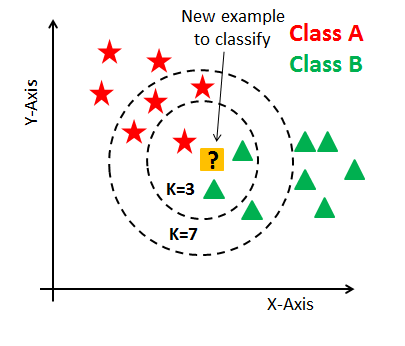

In [10]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k: int):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predicted_labels = []
        for x in X:
            distances = self.count_distance(x, y)
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_indices]
            most_common = Counter(nearest_labels).most_common(1)
            predicted_labels.append(most_common[0][0])
        return np.array(predicted_labels)

    def count_distance(self, x, y):
        return np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

In [11]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [12]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [15]:
data = pd.read_csv('data/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [16]:
# Проверка наличия пропущенных значений
missing_values = data.isnull().sum()
print("Пропущенные значения:")
print(missing_values)

Пропущенные значения:
Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64


Нет, в наборе нет пропущенных значений

In [17]:
# Удаление бессмысленных столбцов (Unnamed: 0)
data = data.drop(['Unnamed: 0'], axis=1)
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [18]:
numeric_features = data.select_dtypes(include=['int64', 'float64'])
numeric_features.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


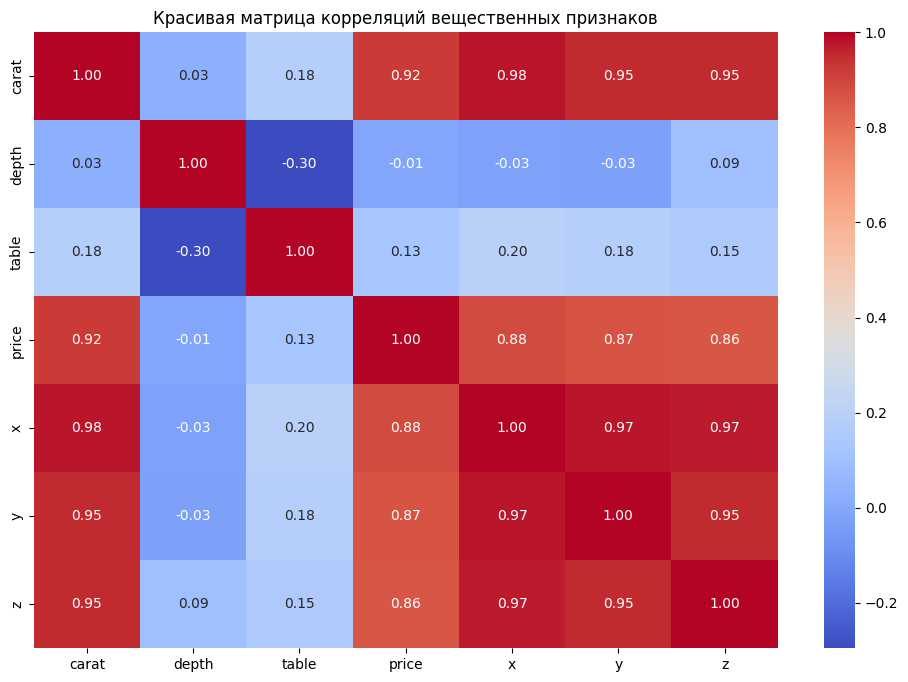

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Красивая матрица корреляций вещественных признаков')
plt.show()

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [20]:
categorical_features = data.select_dtypes(include=['object'])
encoded_features = pd.get_dummies(categorical_features)
processed_data = pd.concat([numeric_features, encoded_features], axis=1)

processed_data.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [21]:
from sklearn.model_selection import train_test_split

X = processed_data.drop('price', axis=1)
y = processed_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер тренировочной выборки: (37758, 26)
Размер тестовой выборки: (16182, 26)


**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

X_test_scaled = X_test.copy()
X_test_scaled[X_test.columns] = scaler.transform(X_test[X_test.columns])


print(X_train_scaled.head())
print(X_test_scaled.head())

          carat     depth     table         x         y         z  cut_Fair  \
19497  0.862659 -0.311437 -0.207099  1.055581  0.986556  0.968253 -0.175082   
31229 -1.029889  0.178549 -0.656213 -1.207734 -1.202544 -1.168276 -0.175082   
22311  0.862659  0.458541 -0.207099  0.904099  0.951670  0.982309 -0.175082   
278    0.021527  0.598537 -1.105327  0.164512  0.192898  0.251391 -0.175082   
6646  -0.020530 -0.031445 -0.656213  0.182333  0.184176  0.181110 -0.175082   

       cut_Good  cut_Ideal  cut_Premium  ...   color_I   color_J  clarity_I1  \
19497 -0.314881   1.227398    -0.585893  ... -0.333294 -0.234494   -0.117361   
31229 -0.314881   1.227398    -0.585893  ... -0.333294 -0.234494   -0.117361   
22311 -0.314881   1.227398    -0.585893  ... -0.333294 -0.234494   -0.117361   
278   -0.314881   1.227398    -0.585893  ... -0.333294 -0.234494   -0.117361   
6646  -0.314881   1.227398    -0.585893  ...  3.000353 -0.234494   -0.117361   

       clarity_IF  clarity_SI1  clarity_SI2 

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Среднеквадратичная ошибка на тренировочной выборке:", mse_train)
print("Среднеквадратичная ошибка на тестовой выборке:", mse_test)

Среднеквадратичная ошибка на тренировочной выборке: 1290541.9147450614
Среднеквадратичная ошибка на тестовой выборке: 1244765.4357158707


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [28]:
coefficients = model.coef_

print("Оценки коэффициентов модели:")
for feature, coef in zip(X_train_scaled.columns, coefficients):
    print(f"{feature}: {coef}")

significant_features = []
for feature, coef in zip(X_train_scaled.columns, coefficients):
    if abs(coef) > 10 * abs(coefficients).mean():
        significant_features.append(feature)

print("\nВещественные переменные с оценками коэффициентов на порядок выше:")
print(significant_features)

Оценки коэффициентов модели:
carat: 5338.615670614762
depth: -90.17381703342323
table: -60.33227991027918
x: -1100.4188500393166
y: -6.458916720538805
z: -34.25894462089235
cut_Fair: -125.7110034412052
cut_Good: -41.39598920939747
cut_Ideal: 51.99220579030468
cut_Premium: 16.46474064458982
cut_Very Good: 1.3708073124382467
color_D: 211.31054123871525
color_E: 162.4826714410842
color_F: 139.7702352224842
color_G: 56.166466787025335
color_H: -130.49754248396115
color_I: -251.21000158162613
color_J: -387.4978278456525
clarity_I1: -473.8257100444955
clarity_IF: 244.2233565041849
clarity_SI1: -146.57593767851893
clarity_SI2: -491.4787844607689
clarity_VS1: 202.57492339556688
clarity_VS2: 102.1803103878024
clarity_VVS1: 253.97293766136386
clarity_VVS2: 271.7804759281613

Вещественные переменные с оценками коэффициентов на порядок выше:
['carat']


**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [34]:
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso(alpha=10)
lasso_model.fit(X_train_scaled, y_train)
lasso_coefficients = lasso_model.coef_

ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train_scaled, y_train)
ridge_coefficients = ridge_model.coef_

print("Оценки коэффициентов для Lasso-регрессии:")
for feature, coef in zip(X_train_scaled.columns, lasso_coefficients):
    print(f"{feature}: {coef}")

print("\nОценки коэффициентов для Ridge-регрессии:")
for feature, coef in zip(X_train_scaled.columns, ridge_coefficients):
    print(f"{feature}: {coef}")

Оценки коэффициентов для Lasso-регрессии:
carat: 4872.156395555542
depth: -57.093610226801644
table: -47.68485714025148
x: -652.157442236506
y: -0.0
z: -43.26536087565864
cut_Fair: -126.50426086138296
cut_Good: -42.8093219815303
cut_Ideal: 41.69581461311703
cut_Premium: 0.0
cut_Very Good: -0.0
color_D: 147.94933994739327
color_E: 92.66322385141818
color_F: 69.13936020331232
color_G: -0.0
color_H: -172.35946256725765
color_I: -279.0145771370216
color_J: -403.03069842773806
clarity_I1: -488.72730005583065
clarity_IF: 194.05330181892637
clarity_SI1: -252.33566450272423
clarity_SI2: -573.6356366611011
clarity_VS1: 101.29825449161235
clarity_VS2: -0.0
clarity_VVS1: 187.4992627278212
clarity_VVS2: 193.99715195310327

Оценки коэффициентов для Ridge-регрессии:
carat: 5301.289061920845
depth: -87.63980472671899
table: -60.123686116655385
x: -1057.2288879020093
y: -9.60514861060856
z: -38.071544191101
cut_Fair: -125.88000002019884
cut_Good: -41.48035465366496
cut_Ideal: 51.96903600640098
cut_Pre



*   Видим, что Lasso обнулила 5 коэффициентов:
 y, cut_Premium, cut_Very Good, color_G, clarity_VS2.

*   Исходя из нашей матрицы было довольно много коррелирующих друг с другом знаечний, однако веса уменьшились не сильно. От -6 до 0, например у "у" или от 56 до 0 у "Color_G". В общей картине сумм подобные нивелирования не сильно изменили ситуацию. Проблема мультиколлинеарности проявлялась, но слабо.

*   Также можно заметить, что Ridge менее агрессивно уменьшает веса в отличие от Lasso.







**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+08, tolerance: 6.061e+07
  model = cd_fast.enet_coordinate_descent(


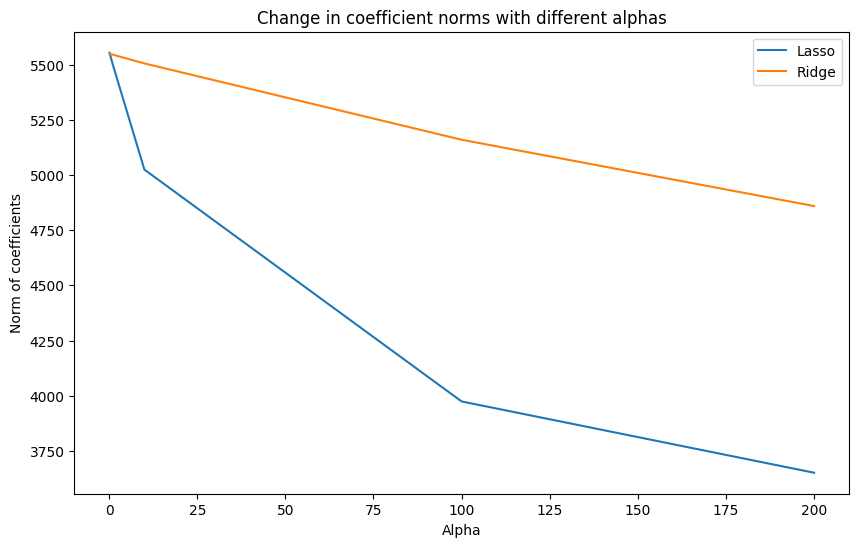

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge

alphas = [0.1, 1, 10, 100, 200]
lasso_norms = []
ridge_norms = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    lasso_norms.append(np.linalg.norm(lasso.coef_))

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_norms.append(np.linalg.norm(ridge.coef_))

plt.figure(figsize=(10, 6))
plt.plot(alphas, lasso_norms, label='Lasso')
plt.plot(alphas, ridge_norms, label='Ridge')
plt.xlabel('Alpha')
plt.ylabel('Norm of сoefficients')
plt.title('Change in сoefficient norms with different alphas')
plt.legend()
plt.show()



*  Как и замечалось ранее, видно, что Lasso агрессивнее уменьшает веса, и стремится свести некторые к нулю. Ridge уменьшает более плавно и умеренно.

*  Для отбора признаков чаще всего используют Lasso, так как за счет ее способности свести веса к нулю или сильно уменьшить веса незначительных признаки, можно отобрать только признаки, которые действительно значительны для модели и не создадут для нее лишний шум.





**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [39]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import numpy as np

alphas = [0.1, 1, 10, 100, 200]

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

errors = lasso_cv.mse_path_

mean_errors = np.mean(errors, axis=1)

optimal_alpha = lasso_cv.alphas_[np.argmin(mean_errors)]

for i, alpha in enumerate(lasso_cv.alphas_):
    print(f"Alpha = {alpha}: MSE = {mean_errors[i]}")

print("\nОптимальное значение alpha:", optimal_alpha)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 665197975.4319, tolerance: 48476565.465277866
  model = cd_fast.enet_coordinate_descent_gram(


Alpha = 200.0: MSE = 3925517.464413105
Alpha = 100.0: MSE = 2630682.372622451
Alpha = 10.0: MSE = 1342874.5484859967
Alpha = 1.0: MSE = 1293886.759374706
Alpha = 0.1: MSE = 1295780.3932733866

Оптимальное значение alpha: 1.0


**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [40]:
lasso_final = Lasso(alpha=optimal_alpha)
lasso_final.fit(X_train, y_train)

print("Коэффициенты модели:")
for i, coef in enumerate(lasso_final.coef_):
    print(f"Признак {i+1}: {coef}")

informative_features = []
non_informative_features = []
for i, coef in enumerate(lasso_final.coef_):
    if coef != 0:
        informative_features.append(i+1)
    else:
        non_informative_features.append(i+1)

print("\nИнформативные признаки:", informative_features)
print("Неинформативные признаки:", non_informative_features)

Коэффициенты модели:
Признак 1: 11078.042618769605
Признак 2: -64.31602875298135
Признак 3: -28.373561315720295
Признак 4: -934.8461376643687
Признак 5: -3.8076672669019858
Признак 6: -34.92856067259062
Признак 7: -713.4062872121356
Признак 8: -137.26540477241693
Признак 9: 98.51935746728309
Признак 10: 28.573513143548066
Признак 11: 0.0
Признак 12: 485.6770642337904
Признак 13: 272.8459221580474
Признак 14: 217.36629622119213
Признак 15: 0.0
Признак 16: -490.6211074409297
Признак 17: -960.9591530631858
Признак 18: -1856.0251662436578
Признак 19: -4355.163911704382
Признак 20: 992.0028634570298
Признак 21: -680.5629508909386
Признак 22: -1643.1236164193103
Признак 23: 213.0204174828469
Признак 24: -94.21254447280343
Признак 25: 651.3515177939893
Признак 26: 582.4447796895238

Информативные признаки: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Неинформативные признаки: [11, 15]


**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [42]:
from sklearn.metrics import mean_squared_error

lasso_predictions = lasso_final.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

print("Среднеквадратичная ошибка Lasso-регрессии:", lasso_mse)
print("Среднеквадратичная ошибка обычной линейной регрессии:", mse_test)

if lasso_mse < mse_test:
    print("Lasso-регрессия показала лучший результат на тестовой выборке")
else:
    print("Обычная линейная регрессия показала лучший результат на тестовой выборке")

Среднеквадратичная ошибка Lasso-регрессии: 1244399.9670519165
Среднеквадратичная ошибка обычной линейной регрессии: 1244765.4357158707
Lasso-регрессия показала лучший результат на тестовой выборке




*   Итог, ошибка у Lasso-регрессии меньше на тестовой выборке, хоть и не сильно меньше линейной регрессии, но она показала результат лучше, поэтому ее лучше использовать для предсказаний.

*   Lasso-регрессия может быть лучше в данном случае из-за своей способности к отбору признаков -- зануляя коэффициенты при неинформативных признаках. Это позволяет избежать переобучения и улучшить адаптивность модели к другим выборкам.

*   Обычная линейная регрессия может быть более склонна к переобучению, если в данных присутствует мультиколлинеарность или большое количество признаков. Однако в нашем случае мультиколлинераность не сильно себя проявлялась и признаков у нас не много.





